# Question 1: TS Forecasting w/ DNN (1-step, multi-step, and multi-ouput forecast)

## 1. 

Read the csv file from the URL and set the first column in the data as the index column.

In [1]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/refs/heads/main/data/US_macro_Quarterly.csv' , index_col=0)
data.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## 2. 

Before moving forward, we first need to change the data frame index type into "datetime"?

In [2]:
data.index = pd.to_datetime(data.index)

## 3. 

Our variable of interest is "cpi" which stand for consumer price index. Keep this variable in the data and drop the rest. 

In [3]:
data = data[['cpi']]

## 4. 

Using Matplotlib, plot the time series for cpi. As you can see, the cpi data is NOT stationary because there is a clear upward trend in the cpi data. Using Deep Neural Networks (DNN), do you think we need to de-trend the cpi data and make it stationary? what are the advantages and disadvantages?

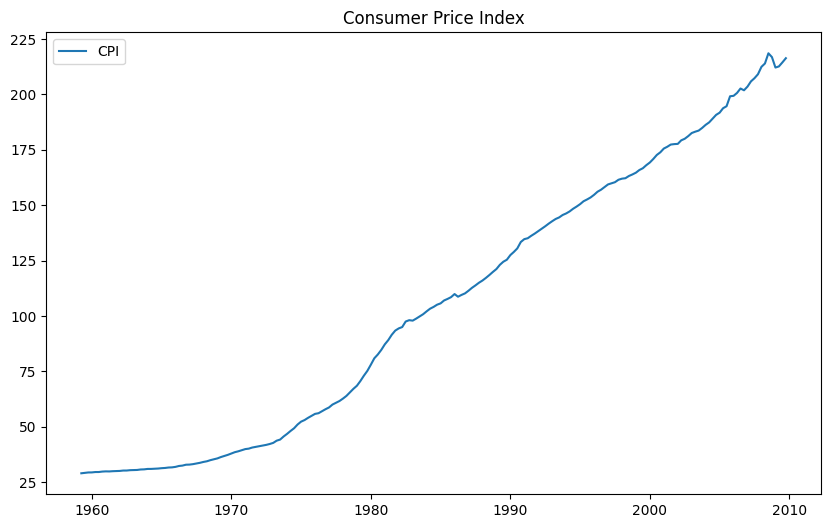

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data, label='CPI')
plt.title('Consumer Price Index')
plt.legend()
plt.show()

Technically DNN can learn the patterns and relationships in the data without needing to make it stationary. Making the data stationary can help the DNN focus on learning the relationships and patterns of the data without being influenced by a trend. 

A disadvantage could be because DNN's can learn the trend and seasonality by removing it from the data the model cannot attempt to learn that information thus the model misses crucial information. 

## 5. 

Prepare your dataset for a supervised deep learning task.

1. test_period = 24. Plot the train-test data to get a sense of what you are going to do for forecasts. 
2. Tx = 8 (using past 2 years ie. 8 quarters) of data to make a forecast for next quarter.
3. Ty = 1 (for one-step ahead forecast) and once needed, Ty=12 (for multi-ouput forecast)
4. At the end of this step, your X and y shapes should be X: (195, 8) and Y:(195,1)

### 1. 

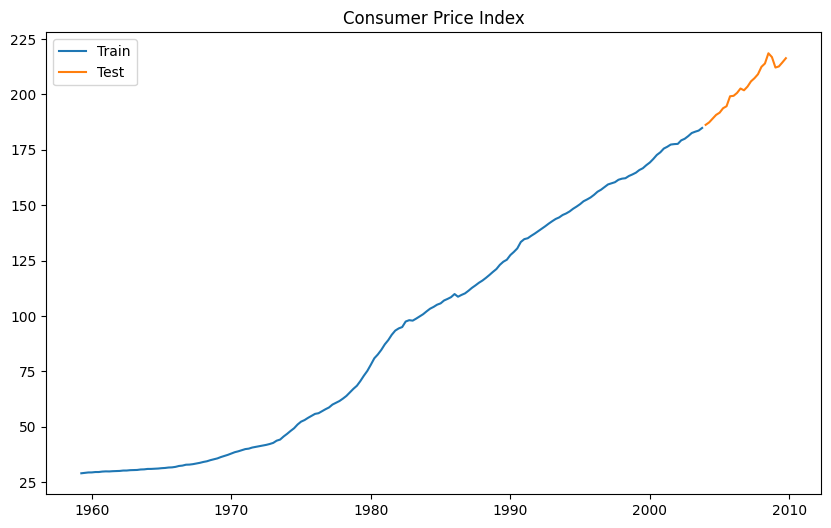

In [5]:
test_period = 24
train_period = len(data) - test_period

train = data[:train_period]
test = data[train_period:]

# plotting the train and test data
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Consumer Price Index')
plt.legend()
plt.show()

In [6]:
# A Boolean series indicating which rows of the DataFrame data belong to each set (train, test)
train_indicator = (data.index <= train.index[-1])
test_indicator =  (data.index > train.index[-1])

### 2-4.

In [7]:
import numpy as np

series = data['cpi'].dropna().to_numpy()

Tx = 8 # Number of lags! using the past Tx observations to forecast the next one.
Ty = 1 #  Forecasting Ty outputs at once
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)])
Y = np.array([series[t+Tx: t+Tx+Ty] for t in range(len(series) - Tx-Ty+1)])
N = len(X)

print(X.shape, Y.shape, N)

(195, 8) (195, 1) 195


## 6. 

Split the data into Xtrain, Ytrain, Xtest, and Ytest using test_period=24

In [8]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

## 7. 

Create your very first DNN model. Feel free to try out any architecture you want with different number of hidden layers and nodes. Here is what you can use for starters:
- Two hidden layers with 32 and 16 nodes respectively. For this example, why it is NOT recommended to use less than 8 nodes in the first hidden layer? 
- Activation functions for the hidden layers can be both "ReLU". In this example, for the output layer you can use either "linear" or "ReLU". why? 
- Loss and metric should be both "mse". 

In [9]:
# creating the DNN model using functional API and build model function.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(Tx, Ty):
    i = Input(shape=(Tx,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    output = Dense(Ty , activation = 'linear')(x)
    model = Model(i, output)
    model.compile(loss='mse', optimizer='adam')
    return model

2024-11-19 06:09:47.814034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732021788.580788 1068114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732021788.778379 1068114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 06:09:50.649249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


It isn't recommended to use less than 8 nodes in the first layer because it would cause a bottleneck and wouldn't capture the most fundamental features. It is a good rule of thumb to have the same number of nodes in the first layer as features in the data. 

In this example both linear and relu can be considered for the output layer due to CPI being positive and typically increasing. Using relu ensure non-negative outputs while linear activation provides flexibility allowing for small decreases if needed.

## 8.

Build the model and report the model.summary(). How many trainable parameters does your model have? Explain in details how you can calculate teh number of parameters for each layer.

In [10]:
model_dnn = build_model(Tx, Ty)
model_dnn.summary()

I0000 00:00:1732021815.379233 1068114 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:03:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

The model has a total of 833 parameters.

The first layer = 8 x 32 + 32

The second layer = 32 x 16 + 16

The final layer = 16 x 1 + 1

## 9. 

Train the model with 100 epochs and batch_size = 16. Also add this callback to your fit argument: EarlyStopping(monitor='val_loss', patience=10)

In [11]:
model_dnn.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=100, batch_size=16, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100


I0000 00:00:1732021818.018994 1068338 service.cc:148] XLA service 0x7fa574006ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732021818.019194 1068338 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-19 06:10:18.147191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732021818.355743 1068338 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21698.2305

I0000 00:00:1732021820.085563 1068338 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - loss: 16514.7070 - val_loss: 27699.9863
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6348.6934 - val_loss: 5590.1680
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1025.2073 - val_loss: 183.4279
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.5500 - val_loss: 286.6106
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.6285 - val_loss: 203.9156
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.1647 - val_loss: 11.6985
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6321 - val_loss: 16.1817
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7720 - val_loss: 9.0374
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0408 - val_loss: 8.1815
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4404 - val_loss: 9.1158
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9036 - val_loss: 7.6282
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

## 10.

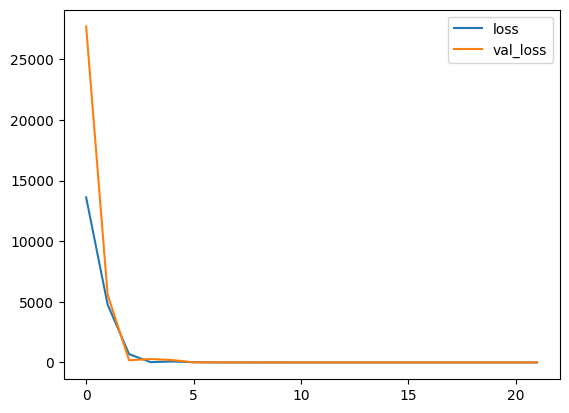

In [12]:
loss_df = pd.DataFrame(model_dnn.history.history)
loss_df[['loss','val_loss']].plot()
plt.show()

Based on the plot above it appears to have stopped training around epoch 22

## 11. 

Great, you are ready to now make some forecasts:
1. Using your dnn model, make 1-step ahead and multiple step ahead forecasts and add these forecasts to your dataset. 
2. Plot the forecasts(both 1-step and multiple-step ahead) for the test set.

### One step ahead forecast

In [13]:
train_indicator[:Tx] = False

In [14]:
dnn_1step_train_forecast = model_dnn.predict(Xtrain)
dnn_1step_test_forecast = model_dnn.predict(Xtest)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [15]:
data.loc[train_indicator, '1step_train_forecast'] = dnn_1step_train_forecast
data.loc[test_indicator, '1step_test_forecast'] = dnn_1step_test_forecast

data.head(10)

,cpi,1step_train_forecast,1step_test_forecast
1959-03-31,28.98,NaN,NaN
1959-06-30,29.15,NaN,NaN
1959-09-30,29.35,NaN,NaN
1959-12-31,29.37,NaN,NaN
1960-03-31,29.54,NaN,NaN
1960-06-30,29.55,NaN,NaN
1960-09-30,29.75,NaN,NaN
1960-12-31,29.84,NaN,NaN
1961-03-31,29.81,30.273817,NaN
1961-06-30,29.92,30.308521,NaN


### Multi step ahead forecasts

In [16]:
multistep_predictions = []

# first test input
input_X = Xtest[0]

# Start a loop that will continue until we have the desired number of future forecasts (test_period).
while len(multistep_predictions) < test_period:
  prediction = model_dnn.predict(input_X.reshape(1, Tx))[0]

  # update the predictions list
  multistep_predictions.append(prediction)

  # update the new input
  # The input_X array, which serves as input for the next prediction, is updated. The np.roll(input_X, -1) shifts all elements of input_X one position to the left.
  # The last element of last_x, which is now freed up, is filled with the last prediction p.
  input_X = np.roll(input_X, -1)
  input_X[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/tmp/ipykernel_1068114/2618387899.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  input_X[-1] = prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [17]:
data.loc[test_indicator, 'multistep_test_forecast'] = multistep_predictions

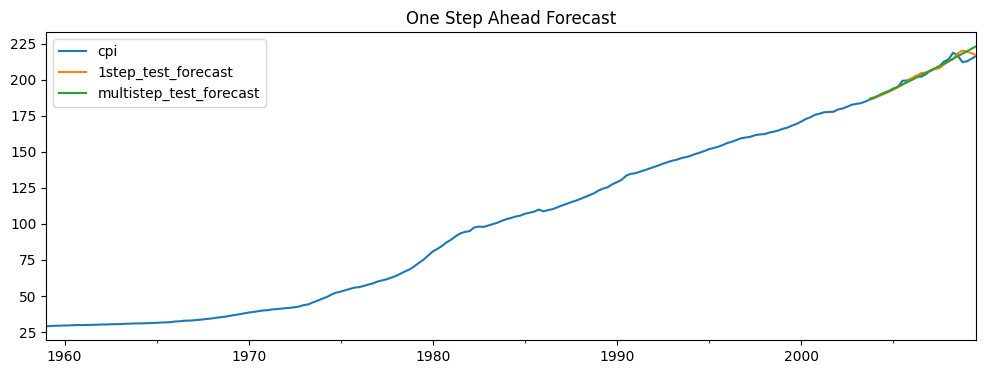

In [18]:
data[['cpi','1step_test_forecast','multistep_test_forecast']].plot(figsize=(12, 4))
plt.title('One Step Ahead Forecast')
plt.show()

## 12. 

Now let's do multi output forecasts using Ty=test_period=24. Remember, you need to make multi-output supervised dataset first and re-train your model on the new trian and validation set. Also make sure you use early stopping callback again. (EarlyStopping(monitor='val_loss', patience=10)).

In [19]:
# Make multi-output supervised dataset
Tx = 8 # recall: using the past Tx lag observations to forecast the next one.
Ty = test_period # number of outputs forecasted at once

# Create input-output pairs
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx - Ty+1)])
Y = np.array([series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty+1)])
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (172, 8) Y: (172, 24) N: 172


In [20]:
Xtrain_mo, Ytrain_mo = X[:-1], Y[:-1]
Xtest_mo, Ytest_mo = X[-1:], Y[-1:]

In [21]:
print(Xtrain_mo.shape, Ytrain_mo.shape, Xtest_mo.shape, Ytest_mo.shape)

(171, 8) (171, 24) (1, 8) (1, 24)


In [22]:
model_DNN_mo = build_model(Tx, Ty)
model_DNN_mo.summary()

# Tx = 12 that is the number of lags
# Ty = 24 that is the number of outputs forecasted at once

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,224 (4.78 KB)

 Trainable params: 1,224 (4.78 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_DNN_mo.fit(Xtrain_mo, Ytrain_mo, epochs=100, batch_size=16, validation_data=(Xtest_mo, Ytest_mo), callbacks=[early_stopping])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 17742.6035 - val_loss: 46492.4062
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15622.9668 - val_loss: 43078.3320
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14380.4990 - val_loss: 38825.7422
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11977.3047 - val_loss: 31950.3477
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10627.4746 - val_loss: 23703.5293
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7399.5767 - val_loss: 15930.1709
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5059.8535 - val_loss: 10292.3232
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3382.3574 - val_loss: 6744.4136
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2257.8252 - val_loss: 4309.4297
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1457.5466 - val_loss: 2620.2725
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 945.3469 - val_

<Axes: >

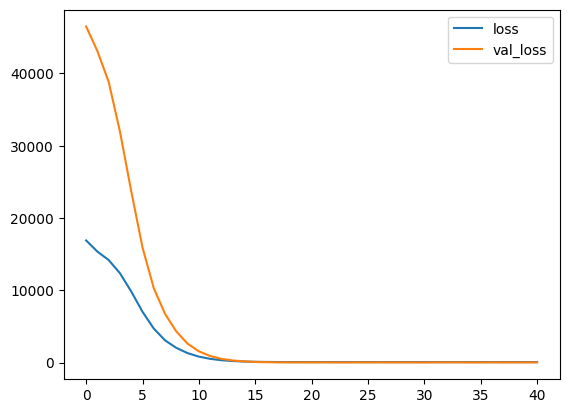

In [24]:
loss_df = pd.DataFrame(model_DNN_mo.history.history)

loss_df[['loss','val_loss']].plot()

The multi-output appears to have stopped training around epoch 40. 

In [25]:
dnn_mo_train_forecast = model_DNN_mo.predict(Xtrain_mo)
dnn_1step_test_forecast = model_DNN_mo.predict(Xtest_mo)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


In [26]:
data.loc[test_indicator, 'multioutput_test_forecast'] = dnn_1step_test_forecast[0]
data.tail()

,cpi,1step_train_forecast,1step_test_forecast,multistep_test_forecast,multioutput_test_forecast
2008-09-30,216.889,NaN,218.066483,216.180161,220.151855
2008-12-31,212.174,NaN,220.186874,217.900208,222.546921
2009-03-31,212.671,NaN,219.287247,219.603729,224.087463
2009-06-30,214.469,NaN,218.410660,221.368011,225.938858
2009-09-30,216.385,NaN,216.858658,223.133835,227.517654


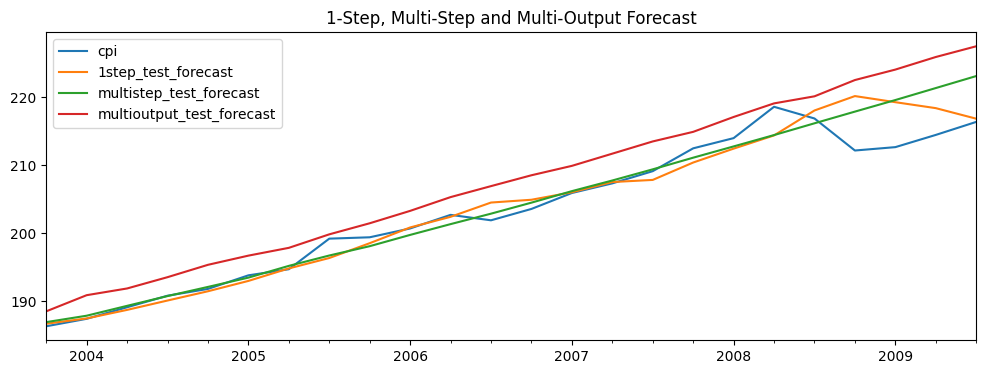

In [27]:
forecasts_only = data.tail(test_period)
forecasts_only[['cpi','1step_test_forecast','multistep_test_forecast','multioutput_test_forecast']].plot(figsize=(12, 4))
plt.title('1-Step, Multi-Step and Multi-Output Forecast')
plt.show()

## 14.

Compare the performance of your DNN model using different forecast types (1-step, multi-step, and multi-output) by reporting the mnape metric for each forecast type in the test set.

In [28]:
from sklearn.metrics import mean_absolute_percentage_error

cpi_test = data.loc[test_indicator, 'cpi']
mape1 = mean_absolute_percentage_error(cpi_test, forecasts_only['1step_test_forecast'])
mape2 = mean_absolute_percentage_error(cpi_test, forecasts_only['multistep_test_forecast'])
mape3 = mean_absolute_percentage_error(cpi_test, forecasts_only['multioutput_test_forecast'])
print('MAPE 1-Step:', mape1)
print('MAPE Multi-Step:', mape2)
print('MAPE Multi-Output:', mape3)

MAPE 1-Step: 0.00808040771993198
MAPE Multi-Step: 0.008952604224820507
MAPE Multi-Output: 0.02123789044150769


The horse race I ran in homework 5 show that arima is winning with a mape of 0.007 which is also better than this DNN model. 